# Deconvolution with FRC and a single image

In [here](http://localhost:8888/notebooks/notebooks/2018-06%20-%20Deconvolution%20with%20Consecutive%20Deconvolution%20estimates.ipynb) and here I demonstrated that applying FRC to deconvolution results is rather challenging, as the deconvolution process make cause for the two images to strongly correlate. Here I show how the deconvolution results can be successfully evaluated with FRC using the checkerboard split method.

In [59]:
%matplotlib inline

import os
import numpy as np

import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

from supertomo.processing.deconvolution import deconvolve
from supertomo.data.wrappers import image_writer_wrappers as imwrap
import supertomo.data.io.read as imread
import supertomo.processing.image as imops
from supertomo.data.containers.image import Image


import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

import supertomo.ui.plots.frc as frcplots





Load *Carma* file into the internal image container class. Then generate a theoretical PSF for deconvolution.

In [60]:
from supertomo.ui import deconvolution_options as options
n_iterations = 60
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=half-bit").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

In [61]:
# Image
data_dir = "/Users/sami/Temp"
filename = "FRC_GaAsP_AU04__.nd2"
full_path = os.path.join(data_dir, filename)

image = imread.get_image(full_path)

image_copy = image.copy()
spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

image = Image(image - image.min(), image.spacing)

The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


Fit starts at 0.625
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 10
         Function evaluations: 20


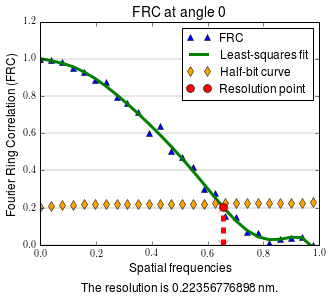

In [62]:
data = FourierCorrelationDataCollection()

image1, image2 = imops.checkerboard_split(image)

frc_task = frc.FRC(image1, image2, args.d_bin)
data[0] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
results = analyzer.execute()

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_one(0)

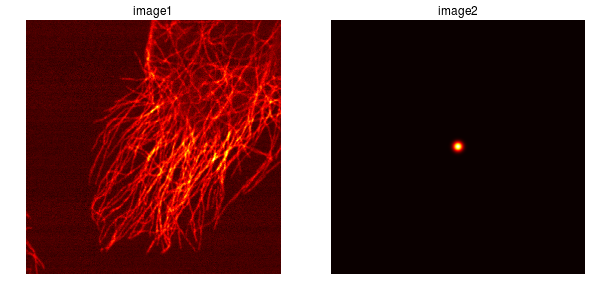

In [63]:
import supertomo.psf.psfgen as psfgen

fwhm = [results[0].resolution['resolution'],] * 2

psf_generator = psfgen.PsfFromFwhm(fwhm)

psf = psf_generator.xy()

showim.display_2d_images(image, psf)



Run deconvolution

In [64]:
from scipy.ndimage import gaussian_filter

#psf = Image(gaussian_filter(psf), psf.spacing)

writer = imwrap.TiffImageWriter(data_dir)

task = deconvolve.DeconvolutionRL(image, psf, writer, args)
task.execute()

The original image size is (512, 512)
The deconvolution will be run with 1 blocks
The internal block size is (512, 512)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/60                ] E/S/U/N=0/21614543/13652643/0, LEAK=-0.503243250782%, TAU1=0.0487364716828, TIME=0.113s, U/ESU=0.387 
Beginning the computation of the 1. estimate
[>                 2/60                ] ETA:6.8s E/S/U/N=0/27241493/8050736/0, LEAK=-0.574608310676%, TAU1=0.0329705476761, TIME=0.111s, U/ESU=0.228 
Beginning the computation of the 2. estimate
[=>                3/60                ] ETA:7.0s E/S/U/N=0/30276729/5017476/0, LEAK=-0.580240384374%, TAU1=0.0262275636196, TIME=0.125s, U/ESU=0.142 
Beginning the computation of the 3. estimate
[==>               4/60                ] ETA:6.6s E/S/U/N=0/31832142/3459186/0, LEAK=-0.57204350866%, TAU1=0.022287895903, TIME=9.89E-2s, U/ESU=9.80E-2 
Beginning the computation of the 4. estimate
[==>               5/60          

[=================41/60===>            ] ETA:1.7s E/S/U/N=608/35211902/25568/0, LEAK=-0.420292671564%, TAU1=0.00587791297585, TIME=8.28E-2s, U/ESU=7.26E-4 
Beginning the computation of the 41. estimate
[=================42/60====>           ] ETA:1.6s E/S/U/N=206/35212852/24537/0, LEAK=-0.418916523098%, TAU1=0.00579560920596, TIME=7.98E-2s, U/ESU=6.96E-4 
Beginning the computation of the 42. estimate
[=================43/60====>           ] ETA:1.6s E/S/U/N=91/35213688/23345/0, LEAK=-0.417576236879%, TAU1=0.00571609521285, TIME=7.81E-2s, U/ESU=6.63E-4 
Beginning the computation of the 43. estimate
[=================44/60=====>          ] ETA:1.5s E/S/U/N=253/35214031/22382/0, LEAK=-0.416270360317%, TAU1=0.0056392760016, TIME=8.27E-2s, U/ESU=6.35E-4 
Beginning the computation of the 44. estimate
[=================45/60======>         ] ETA:1.4s E/S/U/N=52/35214974/21193/0, LEAK=-0.414997706242%, TAU1=0.00556486612186, TIME=8.16E-2s, U/ESU=6.01E-4 
Beginning the computation of the 45. es

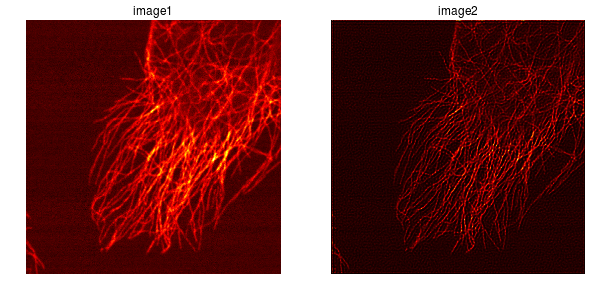

In [65]:
result = task.get_8bit_result()

showim.display_2d_images(image, result)



Show resolution curve

In [66]:

frc_data = FourierCorrelationDataCollection()


for idx in range(n_iterations):
    image_name = "result_{}.tif".format(idx)

    image_path = os.path.join(data_dir, image_name)

    image = read.get_image(image_path)
    image1, image2 = imops.checkerboard_split(image)
    
    frc_task = frc.FRC(image1, image2, args.d_bin)
    frc_data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(frc_data, spacing[0]*sqrt(2), args)
results = analyzer.execute()


Fit starts at 0.703125
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.703125
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.6640625
Optimi

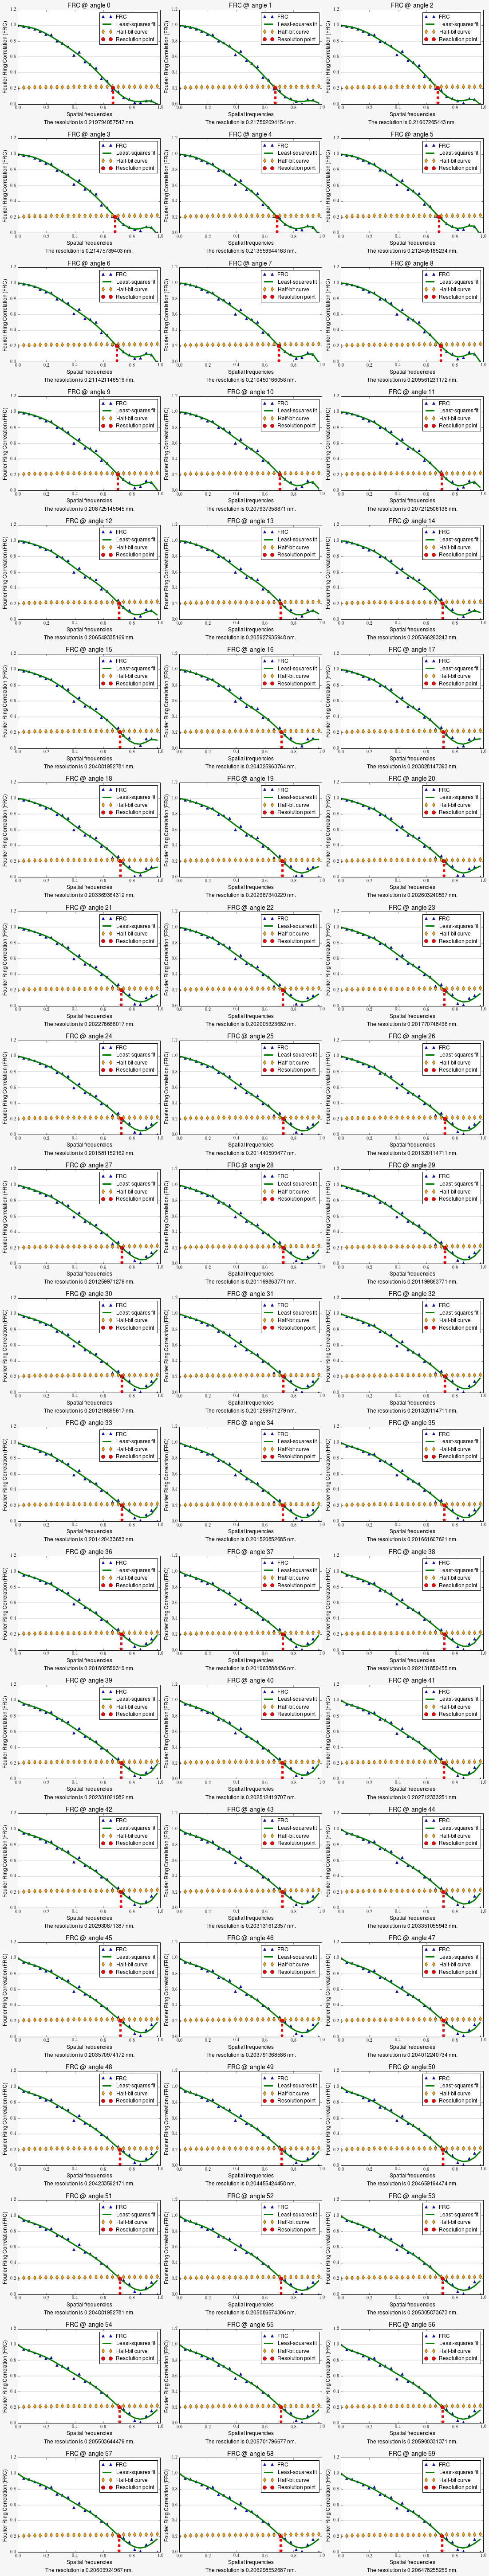

In [67]:

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

## Regarding the measured FRC values

I wanted to see look more closely into how the FRC values behave as a function of the iteration count. The *SuperTomo* deconvolution algorithm also calculates several parameter values that have traditionally been used to evaluate the progress of an iterative deconvolution. For more info, look at (Koho et al 2014). 

Here I normalize all the parameter values (0-1) for easy comparison and plotting. The original values are maintained in the *deconvolution_parameters* dataframe.

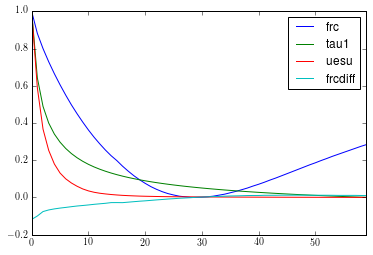

In [68]:
# Get a list of the resolution values as a function of iteration number
iterations = list()
resolutions = list()

for dataset in results:
    iterations.append(int(dataset[0]))
    resolutions.append(dataset[1].resolution["resolution"])

iterations, resolutions = zip(*sorted(zip(iterations, resolutions)))

# Get saved deconvolution parameters
deconvolution_parameters = task.progress_parameters
deconvolution_parameters['frc'] = resolutions


# Set up curves
curves = deconvolution_parameters.loc[:, ['frc', 'tau1', 'uesu']]

curves['frc'] -= curves['frc'].min()
curves['frc'] /= curves['frc'].max()

curves['tau1'] -= curves['tau1'].min()
curves['tau1'] /= curves['tau1'].max()

curves['uesu'] -= curves['uesu'].min()
curves['uesu'] /= curves['uesu'].max() 

curves['frcdiff'] = np.gradient(curves['frc'])



curves.plot()

## Regarding the FRC resolution curve

The FRC resolution value curve behaves in a very interestin way. It is first of all much more linear than *u_esu* and *tau1* and what is quite extraordinary,  the FRC value is able to discern the iteration after which the RL algorithm stops fitting the data, and mainly starts amplifying the noise.

In [69]:
zero_crossing = np.where(np.diff(np.sign(curves['frcdiff'])))[0][0]

print "The deconvolution should be stopped at iteration {}.".format(zero_crossing)

The deconvolution should be stopped at iteration 28.


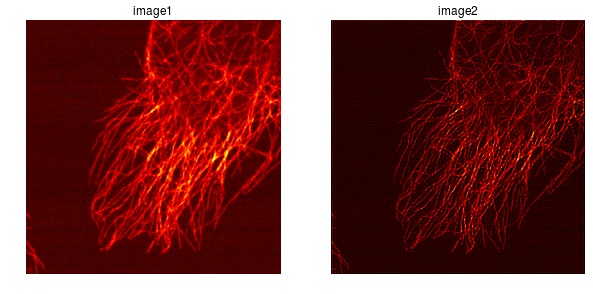

In [70]:
image_path = os.path.join(data_dir, "result_{}.tif".format(zero_crossing))

result_image = read.get_image(image_path)
result_image *= 255/result_image.max()

showim.display_2d_images(image_copy, result_image)


